## Let's demonstrate the stability of linear layers constrained to SO(n) (layers that rotate data in high dimensions)
We will do this by inspecting the activations and gradients of data passed through very deep networks

In [384]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import wandb
from tqdm.auto import tqdm

from son_net import SOnLinear

First, some sanity checks ensuring crucial properties - the determinate of the weight matrix is 1., and the norm of the output equals the norm of the input (rotating something does not change its size)

Let's make some synthetic data for our tests

In [391]:
# simulate some data
BATCH_SIZE = 13
INPUT_DIM = DIM = 128

layer = SOnLinear(DIM, bias=True)
data = torch.randn(BATCH_SIZE, INPUT_DIM)

In [392]:
# assert we have an orthonormal matrix
layer = SOnLinear(DIM, bias=True)
assert layer.weights.det().isclose(torch.tensor(1.), 1e-3)
layer = SOnLinear(DIM, bias=False)
assert layer.weights.det().isclose(torch.tensor(1.), 1e-3)


# ensure we've only rotated the input data, not scaled it
layer = SOnLinear(DIM, bias=False)
output = layer(data)
assert output.norm(dim=1).isclose(data.norm(dim=1)).all()

layer = SOnLinear(DIM, bias=True)
output = layer(data)
assert (output - layer.bias).norm(dim=1).isclose(data.norm(dim=1)).all()

### build our networks that we will pass data through for testing

In [393]:
# init models
DEPTH = 1001
NONLINEARITY, NLNAME = nn.Tanh(), "tanh"

# make two very deep MLPs
control, rubiks = [], []
for d in range(DEPTH):
    control += [nn.Linear(DIM, DIM, bias=False), NONLINEARITY]
    rubiks += [SOnLinear(DIM, bias=False), NONLINEARITY]
control = nn.Sequential(*control)
rubiks = nn.Sequential(*rubiks)

# register hooks for inspection
activation = {}
grad = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_grad(name):
    def hook(model, grad_input, grad_output):
        grad[name] = grad_output[0].detach()
    return hook

for d in range(DEPTH):
    control[d*2].register_forward_hook(get_activation(f"control_{d}"))
    rubiks[d*2].register_forward_hook(get_activation(f"rubiks_{d}"))

for d in range(DEPTH):
    control[d*2].register_backward_hook(get_grad(f"control_{d}"))
    rubiks[d*2].register_backward_hook(get_grad(f"rubiks_{d}"))



### forward and backward passes, collecting activation and gradient norms

In [394]:
# init optimizers to inspect gradients
# forward and backward pass through the network
control_out = control(data)
rubiks_out = rubiks(data)

closs = nn.functional.mse_loss(control_out, data)
rloss = nn.functional.mse_loss(rubiks_out, data)

closs.backward()
rloss.backward()

# collect the activation and gradient norms for both passes
control_norms, rubiks_norms = [], []
control_grad_norms, rubiks_grad_norms = [], []
for d in range(DEPTH):
    c = f"control_{d}"
    r = f"rubiks_{d}"

    control_norms.append(activation[c].norm(dim=1).mean())
    rubiks_norms.append(activation[r].norm(dim=1).mean())

    control_grad_norms.append(grad[c].norm(dim=1).mean())
    rubiks_grad_norms.append(grad[r].norm(dim=1).mean())

/Users/jsb/miniconda3/envs/p310/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


### Plot activation and gradient norm results

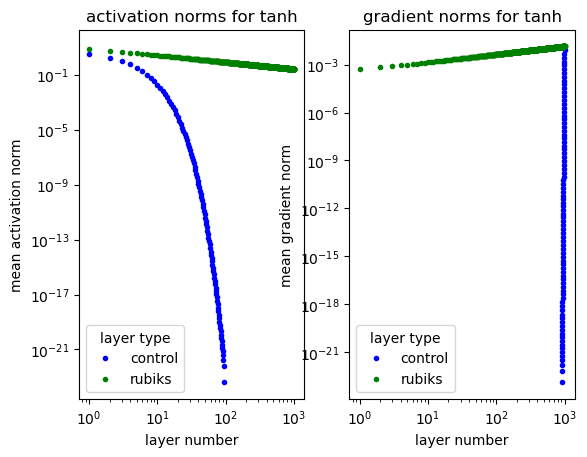

In [395]:
# plot our results
fig, axes = plt.subplots(1, 2)

# activations
ax = axes[0]
ax.set_title(f'activation norms for {NLNAME}')
cl = ax.plot(control_norms, 'b.', label="control")
rl = ax.plot(rubiks_norms, 'g.', label="rubiks")
ax.legend(title="layer type")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("mean activation norm")
ax.set_xlabel("layer number")

# grads
ax = axes[1]
ax.set_title(f'gradient norms for {NLNAME}')
cl = ax.plot(control_grad_norms, 'b.', label="control")
rl = ax.plot(rubiks_grad_norms, 'g.', label="rubiks")
ax.legend(title="layer type")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("mean gradient norm")
ax.set_xlabel("layer number")

plt.show()



Activation and gradient norms barely shrink in the SO(n)/Rubik's case!
Note that shrinkage will always occur do to the tanh nonlinearity, though it happens very slowly and never in a vanishing way

## Demo: training a very deep network on FashionMNIST

A traditional MLP, even with SOTA optimizers such as AdamW, will never get off the ground in training.
A network with SO(n) layers will learn even when absurdly deep

#### define MLP that can use regular or SO(n) layers

In [396]:
# make two very deep MLPs
class MLP(nn.Module):
    def __init__(
        self,
        so_n: bool,
        dim_input: int,
        dim_hidden: int,
        dim_output: int,
        num_hidden: int,
        activation_fn: nn.Module,
    ):
        super().__init__()
        self.activation_fn = activation_fn
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden
        self.dim_output = dim_output
        self.num_hidden = num_hidden
        self.so_n = so_n
        if so_n:
            hidden_layer = SOnLinearnLinear
        else:
            hidden_layer = nn.Linear

        self.readin = nn.Linear(dim_input, dim_hidden)

        hidden_layers = []
        for i in range(num_hidden):
            hidden_layers.append(hidden_layer(dim_hidden, dim_hidden, bias=False))
        self.hidden_layers = nn.ModuleList(hidden_layers)

        self.readout = nn.Linear(dim_hidden, dim_output)
    
    def forward(self, x):
        x = self.readin(x)
        for layer in self.hidden_layers:
            x = self.activation_fn(layer(x))
        x = self.readout(x)
        return x

#### build dataset

In [397]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.reshape(-1),
])

dataset = FashionMNIST(
    './data', 
    train=True, 
    download=True, 
    transform=transform,
)

test_dataset = FashionMNIST(
    './data', 
    train=False, 
    download=True, 
    transform=transform,
)

loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)

#### build networks

In [398]:
dim_input = dataset[0][0].shape[0]
dim_output = 10
DIM_HIDDEN = 128

# init models
DEPTH = 1001
NONLINEARITY, NLNAME = nn.Tanh(), "tanh"

# make two very deep MLPs
class MLP(nn.Module):
    def __init__(
        self,
        so_n: bool,
        dim_input: int,
        dim_hidden: int,
        dim_output: int,
        num_hidden: int,
        activation_fn: nn.Module,
    ):
        super().__init__()
        self.activation_fn = activation_fn
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden
        self.dim_output = dim_output
        self.num_hidden = num_hidden
        self.so_n = so_n
        if so_n:
            hidden_layer = SOnLinear
        else:
            hidden_layer = nn.Linear

        self.readin = nn.Linear(dim_input, dim_hidden)

        hidden_layers = []
        for i in range(num_hidden):
            if so_n:
                hidden_layers.append(SOnLinear(dim_hidden, bias=False))
            else:
                hidden_layers.append(nn.Linear(dim_hidden, dim_hidden, bias=False))

        self.hidden_layers = nn.ModuleList(hidden_layers)
        self.readout = nn.Linear(dim_hidden, dim_output)
    
    def forward(self, x):
        x = self.readin(x)
        for layer in self.hidden_layers:
            x = self.activation_fn(layer(x))
        x = self.readout(x)
        return x

NUM_LAYERS = 1024
control = MLP(
    so_n=False,
    dim_input=784,
    dim_hidden=128,
    dim_output=10,
    num_hidden=NUM_LAYERS,
    activation_fn=nn.Tanh()
)

rubiks = MLP(
    so_n=True,
    dim_input=784,
    dim_hidden=128,
    dim_output=10,
    num_hidden=NUM_LAYERS,
    activation_fn=nn.Tanh()
)

# build optimizers for our models
copt = torch.optim.AdamW(params=control.parameters(), lr=1e-3)
ropt = torch.optim.AdamW(params=rubiks.parameters(), lr=1e-3)



#### define training/eval loop    

In [402]:
def run_epoch(loader, train: bool, split: str, max_n: None | int = None):
    if train:
        control.train()
        rubiks.train()
    else:
        control.eval()
        rubiks.eval()

    n = 0
    ccorrect = 0.
    rcorrect = 0.
    total_rloss = 0.
    total_closs = 0.
    for batch in tqdm(loader, position=1, leave=False):
        if train:
            copt.zero_grad()
            ropt.zero_grad()
        
        x, y = batch
        n += x.shape[0]
        
        yc = control(x)
        yr = rubiks(x)
        closs = nn.functional.cross_entropy(yc, y, reduction='sum')
        rloss = nn.functional.cross_entropy(yr, y, reduction='sum')

        if train:
            (closs / x.shape[0]).backward()
            (rloss / x.shape[0]).backward()
    
            copt.step()
            ropt.step()
    
        ccorrect += (yc.argmax(dim=1) == y).sum().item()
        rcorrect += (yr.argmax(dim=1) == y).sum().item()

        total_rloss += rloss.item()
        total_closs += closs.item()
        if max_n and n >= max_n:
            break

    metrics = {
        f'{split}/control_loss': total_closs / n,
        f'{split}/rubiks_loss': total_rloss / n,
        f'{split}/control_acc': ccorrect / n,
        f'{split}/rubiks_acc': rcorrect / n,
    }
               
    return metrics

#### prepare logging

In [400]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [374]:
run_id = np.random.randint(int(1e9))

wandb.init(
    name=f"run_id={run_id}",
    project=f"rubiks_depth_test"
)

#### beging training

In [403]:
pbar = tqdm(range(2), position=0, leave=True)
description = f""
for epoch in range(2):
    description = f"epoch {epoch}"
    train_metrics = run_epoch(loader, train=True, split='train', max_n=5_000)
    eval_metrics = run_epoch(test_loader, train=True, split='test', max_n=1_000)

    for k, v in train_metrics.items():
        description += f' | {k}: {v:0.3f}'
        
    for k, v in eval_metrics.items():
        description += f' | {k}: {v:0.3f}'
    pbar.update(1)
    pbar.set_description(description)
    wandb.log({**train_metrics, **eval_metrics})

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [404]:
# performance after 1 ep
for k, v in {**train_metrics, **eval_metrics}.items():
    print(f"{k}: {v:0.3f}")

train/control_loss: 2.303
train/rubiks_loss: 2.246
train/control_acc: 0.099
train/rubiks_acc: 0.390
test/control_loss: 2.302
test/rubiks_loss: 2.262
test/control_acc: 0.106
test/rubiks_acc: 0.355
